In [ ]:
#This notebook is to look at the accumulated charge distribution and
# subtract either the estimate bkg using the error rate or the observed bkg.
# It takes the bitstrings and test the performance of the mitigation in one of the Trotter step.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import math
list(colormaps)
cmap = 'gist_heat'

def checkZ2Charge(key):
    ''' 
    This function takes a bitstring key and returns the charge information.
    One key notice: the charge output tracks the number of 1s in the bitstring by summing the values
    However, the number of charges is defined as the number of 0s.
    the real "charge number" should be nsites - charge.
    '''
    charge = []
    for i in np.arange(0,len(key),1): # Assuming first and last are matter site.

        if i%2 == 0:
            charge.append(int(key[i]))
    charge = np.array(charge)
    return charge

nSites = 27
matter_defect=[27]
initial_charge = 26
initialKey = '10101010101010101010101010001010101010101010101010101'
initialCharge_key = checkZ2Charge(initialKey)
#evo_strings_name  = "Torino_53RealTimeEvo_2025-05-27_strings.pkl"
evo_strings_name = "../Torino_53RealTimeEvo_2025-07-28_strings.pkl"
evo_strings = np.load(evo_strings_name ,allow_pickle=True)

In [2]:
evo_ind = 2 # Index of the Trotter step used to test the mitigation technique.
keyList = list(evo_strings.keys())
evo = evo_strings[keyList[evo_ind]]
print(keyList[evo_ind]) 


nTrotter_3_evo_0.4000000000000001


In [3]:
def getNstrings(strings_set):
    ''' 
    This function loops through sets of bitstrings and count the total number of strings
    '''
    nStrings = np.zeros(nSites+1)
    sum_all = 0
    for subset in strings_set:
        #print("Starting new subset")
        for string_key in subset.keys():
            charge_arr = checkZ2Charge(string_key)
            nCharges = nSites - sum(charge_arr)
            sum_all += subset[string_key]
            nStrings[nCharges] += subset[string_key]
    print("Total sum of strings: ", sum_all)
    return nStrings, sum_all
    


def buildP_all(strings_set,nCharge_max = 15):
    ''' 
    Builds the probability distribution based on the set of strings.
    nCharge_max sets the maximum number of charges allowed to be observed.
    For each nCharge observed, the probability distribution is recorded separately.
    Technically, the site has no charge if it is 1 and has a charge when 0. But this is not intuitive. We wanna switch this.
    In the end, returning 1-p such that the 0 < - > 1 conversion is handled for all sites.
    '''

    p = np.zeros((nCharge_max, nSites)) # recording distribution for all charge observations
    sum_all = np.zeros(nCharge_max) # recording total number of strings for each charge observation
    for subset in strings_set:
        #print("Starting new subset")
        for string_key in subset.keys():
            charge_arr = checkZ2Charge(string_key)
            nCharges = nSites - charge_arr.sum()
            if nCharges >= nCharge_max:
                continue

            sum_all[nCharges] += subset[string_key]
            p[nCharges] += charge_arr * subset[string_key]
    p = np.array(p)
    for i in range(nCharge_max):
        if sum_all[i] == 0:
            continue
        p[i] /= sum_all[i]

    print("Total sum of strings: ", sum_all.sum())
    return 1 - p, sum_all
    

def prob_n_charges(n, E, n_charge,return_separate = False):
    ''' 
    Calculates the probability of observing a certain number of charges based on the noise model.
    n: number of sites
    E: average Error rate
    n_charge: number of charges observed
    '''
    if n_charge < 0 or n_charge > n:
        if return_separate:
            return 0, 0
        else:
            return 0
        return 0
    binom = math.comb
    term1 = 0 #with real charge
    if 1 <= n_charge <= n:
        term1 = (1 - E) * binom(n - 1, n_charge - 1) * (E ** (n_charge - 1)) * ((1 - E) ** (n - n_charge))
    
    term2 = 0 #without real charge
    if 0 <= n_charge <= n - 1:
        term2 = E * binom(n - 1, n_charge) * (E ** n_charge) * ((1 - E) ** (n - 1 - n_charge))
    
    if return_separate:
        return term1, term2
    
    else:
        return term1 + term2
        
def getPlist(E,n = nSites):
    ''' 
    For a range of nCharges observed, get the probability distribution for each.
    '''
    p = []
    #probability observing 0 charges is that the charged one must flip
    p.append((1-E)**(nSites - 1) * E) 
    for l in np.arange(1,n,1):
        p.append(prob_n_charges(nSites,E,l))
    p = np.array(p)
    return p

def getPbest(nStrings):
    ''' 
    Use the strings observed to find the best probability distribution.
    ''' 
    p_obs = nStrings/nStrings.sum()
    mean_obs = (p_obs * np.arange(0, len(p_obs),1)).sum()
    E_best = (mean_obs - 1)/(nSites - 2)
    p_best = getPlist(E_best)
    return p_best,E_best



In [4]:
nStrings, sum_all = getNstrings(evo)
tmp_p,tmp_E = getPbest(nStrings)
print("Best E: ", tmp_E)
nCharge_max = 20
p_charge_list, nCharges_list = buildP_all(evo,nCharge_max = nCharge_max)
nCharges_list_norm = nCharges_list / nCharges_list.sum()
tmp_p, tmp_E = getPbest(nCharges_list)


Total sum of strings:  2000000
Best E:  0.21143514
Total sum of strings:  1999998.0


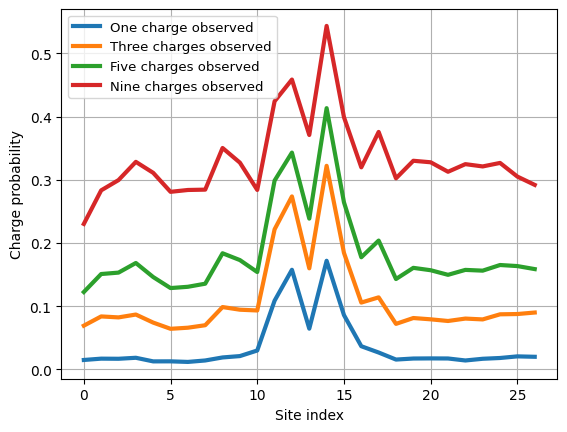

In [5]:

plt.plot(p_charge_list[1],linewidth = 3, label = 'One charge observed')
plt.plot(p_charge_list[3],linewidth = 3, label = 'Three charges observed')
plt.plot(p_charge_list[5],linewidth = 3, label = 'Five charges observed')
plt.plot(p_charge_list[9],linewidth = 3, label = 'Nine charges observed')
#plt.plot(p_charge_list[14],linewidth = 3, label = 'Fourteen charge observed')
plt.xlabel('Site index')
plt.ylabel('Charge probability')
plt.legend(loc = 'upper left', fontsize = 9.5)
plt.grid()
plt.savefig(f'ChargeProbability_trotter{evo_ind}_a.png', dpi=300, bbox_inches='tight')

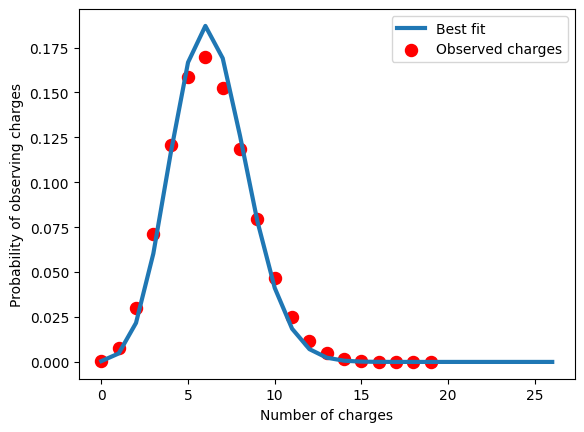

In [6]:
charge_range = range(0,nCharge_max,1)  # Charge range from 1 to nSites - 1

plt.plot(range(0,27,1),getPlist(tmp_E),linewidth = 3,label = 'Best fit')
plt.scatter(charge_range,nCharges_list_norm,color = 'r',s=75,label = 'Observed charges')
plt.xlabel('Number of charges')
plt.ylabel('Probability of observing charges')
# plt.xlim(0,15)
plt.legend()
plt.savefig('fit.png', dpi=300, bbox_inches='tight')

In [7]:
def getFactors(tmp_E):
    '''
    Computes the Bayesian factors based on the observed average error rate.
    In the document, we have already expressed these factors using p(nc,ns,E), which could be computed using prob_n_charges.
    '''
    f_bt_list = []
    f_bf_list = []
    p_nc_list = []

    for tmp_n_charge in charge_range:
        #p(nc,ns):
        p_nc = prob_n_charges(nSites, tmp_E, tmp_n_charge,return_separate = False)
        p_nc_list.append(p_nc)

        #Should pick term 1?
        f_bt =  prob_n_charges(nSites, tmp_E, tmp_n_charge,return_separate = True)[0]
        f_bt /= p_nc
        f_bt_list.append(f_bt)

        f_bf_numerator = prob_n_charges(nSites - 1, tmp_E, tmp_n_charge - 1,return_separate = False)
        f_bf_denominator = prob_n_charges(nSites, tmp_E, tmp_n_charge,return_separate = False) 
        f_bf = f_bf_numerator / f_bf_denominator
        f_bf_list.append(f_bf)

    f_bt_list = np.array(f_bt_list)
    f_bf_list = np.array(f_bf_list)
    p_nc_list = np.array(p_nc_list)

    return f_bt_list, f_bf_list, p_nc_list

In [8]:
f_bt_list, f_bf_list, p_nc_list = getFactors(tmp_E)

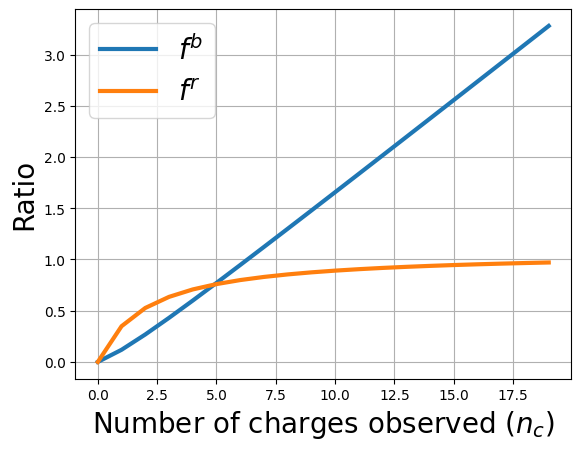

In [9]:

plt.plot(charge_range,f_bf_list,linewidth = 3, label = '$f^{b}$')
plt.plot(charge_range,f_bt_list,linewidth = 3, label = '$f^{r}$')
plt.xlabel('Number of charges observed ($n_{c}$)', fontsize=20 )
plt.ylabel('Ratio', fontsize=20)
#legend with large size
plt.legend(fontsize=20)
#tick size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.savefig(f"Bayesian_Factors_{evo_ind}",dpi=300, bbox_inches='tight')

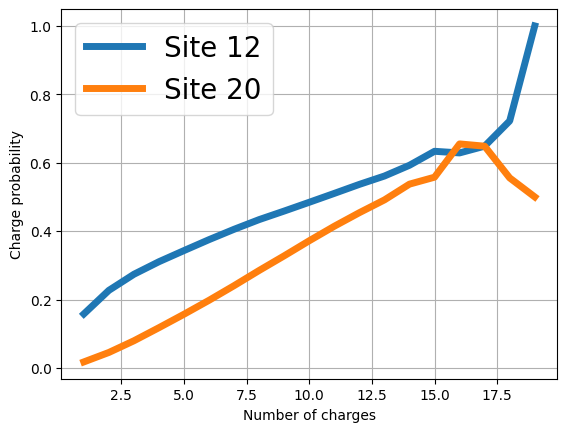

In [10]:
xx = np.arange(1,nCharge_max,1)
plt.plot(xx,p_charge_list[1:,12],linewidth = 5,label = 'Site 12')
#plt.plot(xx,p_charge_list[1:,13],label = 'Site 13')
#plt.plot(xx,p_charge_list[1:,14],label = 'Site 14')
plt.plot(xx,p_charge_list[1:,20],linewidth = 5,label = 'Site 20')
#plt.plot(xx,p_charge_list[1:,21],label = 'Site 21')
#plt.plot(xx,p_charge_list[1:,22],label = 'Site 22')
plt.legend(fontsize=20)
plt.xlabel('Number of charges')
plt.ylabel('Charge probability')
plt.grid()
plt.savefig(f'ChargeProbability_trotter_{evo_ind}_b.png', dpi=300, bbox_inches='tight')

In [11]:
#I want to set the fitting range to be those with sufficient data.
# For example, set start and end to be those with entries in nCharges_list being more than some threshold
n_threshold = 5000
fit_lower_limit = np.where(nCharges_list > n_threshold)[0][0]
fit_upper_limit = np.where(nCharges_list > n_threshold)[0][-1] + 1
print("Fitting range: ", fit_lower_limit, fit_upper_limit)


Fitting range:  1 14


In [12]:
from scipy.optimize import curve_fit
#Perform the fit with pr and pf floated.
def model_func(nc_factors, pr, pf):
    f_bt, f_bf = nc_factors
    return f_bt * pr + (1-pr*f_bt/(1-pf))*f_bf * pf 

n_sites = p_charge_list.shape[1]

pr_list = []
pf_list = []

for i in range(n_sites):
    y = p_charge_list[fit_lower_limit:fit_upper_limit, i]
    f_bt = f_bt_list[fit_lower_limit:fit_upper_limit]
    f_bf = f_bf_list[fit_lower_limit:fit_upper_limit]
    # curve_fit expects the independent variable as the first argument, so stack f_bt and f_bf
    popt, _ = curve_fit(model_func, (f_bt, f_bf), y, bounds=([0, 0], [1, 0.8]),p0=[0.1,0.3])
    pr_list.append(popt[0])
    pf_list.append(popt[1])

pr_list = np.array(pr_list)
pf_list = np.array(pf_list)

1.3768599055541728 5.609855576068


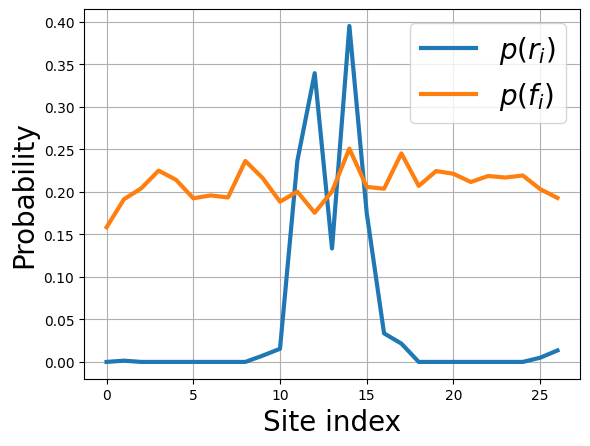

In [13]:
plt.plot(pr_list,linewidth = 3, label='$p(r_{i})$')
plt.plot(pf_list,linewidth = 3, label='$p(f_{i})$')
plt.xlabel('Site index', fontsize=20 )
plt.ylabel('Probability',   fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.legend(fontsize=20)
plt.savefig('pr_pf_fit.png', dpi=300, bbox_inches='tight')
print(pr_list.sum(), pf_list.sum())
